train ctrnn


 ****** Running generation 0 ****** 

Population's average fitness: 0.26604 stdev: 0.10562
Best fitness: 1.12000 - size: (2, 6) - species 5 - id 161
Average adjusted fitness: 0.091
Mean genetic distance 2.574, standard deviation 0.677
Population of 251 members in 13 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0     7      0.8    0.118     0
     2    0    21      0.4    0.092     0
     3    0    10      0.5    0.096     0
     4    0    26      0.4    0.099     0
     5    0    35      1.1    0.143     0
     6    0     2      0.8    0.094     0
     7    0    24      0.3    0.063     0
     8    0     8      0.4    0.075     0
     9    0     5      0.4    0.075     0
    10    0    23      0.3    0.065     0
    11    0    27      0.3    0.113     0
    12    0    56      0.4    0.085     0
    13    0     7      0.2    0.070     0
Total extinctions: 0
Generation time: 0.109 sec

 ****** Running generation 1 ****** 

Popula

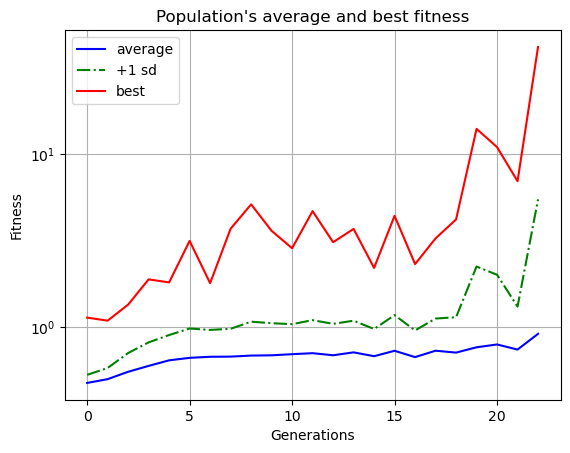

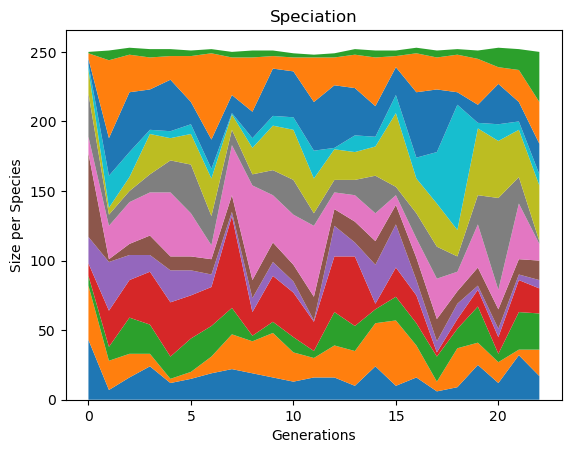

In [43]:
import multiprocessing
import os
import pickle
import cart_pole
import neat
import visualize

runs_per_net = 5
simulation_seconds = 60.0
time_const = cart_pole.CartPole.time_step


# Use the CTRNN network phenotype and the discrete actuator force function.
def eval_genome(genome, config):
    net = neat.ctrnn.CTRNN.create(genome, config, time_const)

    fitnesses = []
    for runs in range(runs_per_net):
        sim = cart_pole.CartPole()
        net.reset()

        # Run the given simulation for up to num_steps time steps.
        fitness = 0.0
        while sim.t < simulation_seconds:
            inputs = sim.get_scaled_state()
            action = net.advance(inputs, time_const, time_const)

            # Apply action to the simulated cart-pole
            force = cart_pole.discrete_actuator_force(action)
            sim.step(force)

            # Stop if the network fails to keep the cart within the position or angle limits.
            # The per-run fitness is the number of time steps the network can balance the pole
            # without exceeding these limits.
            if abs(sim.x) >= sim.position_limit or abs(sim.theta) >= sim.angle_limit_radians:
                break

            fitness = sim.t

        fitnesses.append(fitness)

        # print("{0} fitness {1}".format(net, fitness))

    # The genome's fitness is its worst performance across all runs.
    return min(fitnesses)


def run():
    # Load the config file, which is assumed to live in
    # the same directory as this script.
    local_dir = os.path.dirname("/media/adi/032E-9FF0/ml/rl/rl-neat-self-balancing-robot-sim-and-algo/rl/config-ctrnn")
    config_path = os.path.join(local_dir, 'config-ctrnn')
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_path)

    pop = neat.Population(config)
    stats = neat.StatisticsReporter()
    pop.add_reporter(stats)
    pop.add_reporter(neat.StdOutReporter(True))

    pe = neat.ParallelEvaluator(multiprocessing.cpu_count(), eval_genome)
    winner = pop.run(pe.evaluate)

    # Save the winner.
    with open('winner-ctrnn', 'wb') as f:
        pickle.dump(winner, f)

    print(winner)

    visualize.plot_stats(stats, ylog=True, view=True, filename="ctrnn-fitness.svg")
    visualize.plot_species(stats, view=True, filename="ctrnn-speciation.svg")

    node_names = {-1: 'x', -2: 'dx', -3: 'theta', -4: 'dtheta', 0: 'control'}
    visualize.draw_net(config, winner, True, node_names=node_names)

    visualize.draw_net(config, winner, view=True, node_names=node_names,
                       filename="winner-ctrnn.gv")


if __name__ == '__main__':
    run()


test ctrnn

In [44]:
import os
import pickle
import neat
from cart_pole import CartPole, discrete_actuator_force
from movie import make_movie
# load the winner
with open('winner-ctrnn', 'rb') as f:
    c = pickle.load(f)

print('Loaded genome:')
print(c)

# Load the config file, which is assumed to live in
# the same directory as this script.
local_dir = os.path.dirname("/media/adi/032E-9FF0/ml/rl/rl-neat-self-balancing-robot-sim-and-algo/rl/config-ctrnn")
config_path = os.path.join(local_dir, 'config-ctrnn')

config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_path)

sim = CartPole()

net = neat.ctrnn.CTRNN.create(c, config, sim.time_step)

print()
print("Initial conditions:")
print("        x = {0:.4f}".format(sim.x))
print("    x_dot = {0:.4f}".format(sim.dx))
print("    theta = {0:.4f}".format(sim.theta))
print("theta_dot = {0:.4f}".format(sim.dtheta))
print()

# Run the given simulation for up to 120 seconds.
balance_time = 0.0
while sim.t < 120.0:
    inputs = sim.get_scaled_state()
    action = net.advance(inputs, sim.time_step, sim.time_step)

    # Apply action to the simulated cart-pole
    force = discrete_actuator_force(action)
    sim.step(force)

    # Stop if the network fails to keep the cart within the position or angle limits.
    # The per-run fitness is the number of time steps the network can balance the pole
    # without exceeding these limits.
    if abs(sim.x) >= sim.position_limit or abs(sim.theta) >= sim.angle_limit_radians:
        break

    balance_time = sim.t

print('Pole balanced for {0:.1f} of 120.0 seconds'.format(balance_time))

print()
print("Final conditions:")
print("        x = {0:.4f}".format(sim.x))
print("    x_dot = {0:.4f}".format(sim.dx))
print("    theta = {0:.4f}".format(sim.theta))
print("theta_dot = {0:.4f}".format(sim.dtheta))
print()
print("Making movie...")
make_movie(net, discrete_actuator_force, 15.0, "ctrnn-movie.mp4")


Loaded genome:
Key: 5014
Fitness: 60.00999999999663
Nodes:
	0 DefaultNodeGene(key=0, bias=-1.7082621150141915, response=1.0, activation=sigmoid, aggregation=sum)
	403 DefaultNodeGene(key=403, bias=-0.08803736487547838, response=1.0, activation=sigmoid, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-4, 0), weight=0.6938190801793265, enabled=True)
	DefaultConnectionGene(key=(-3, 0), weight=2.567185220085704, enabled=True)
	DefaultConnectionGene(key=(-3, 403), weight=-2.2963227084043094, enabled=True)
	DefaultConnectionGene(key=(-2, 403), weight=0.91541968978624, enabled=True)
	DefaultConnectionGene(key=(-1, 0), weight=-0.5197385885151918, enabled=False)
	DefaultConnectionGene(key=(-1, 403), weight=0.5510304036861459, enabled=True)
	DefaultConnectionGene(key=(403, 0), weight=0.8196416226041503, enabled=True)
	DefaultConnectionGene(key=(403, 403), weight=-0.06302166637082746, enabled=True)

Initial conditions:
        x = -0.7880
    x_dot = 0.3820
    theta = -0.2626
theta_dot

Moviepy - Done !
Moviepy - video ready ctrnn-movie.mp4


train feedforward


 ****** Running generation 0 ****** 

Population's average fitness: 0.26152 stdev: 0.14327
Best fitness: 1.35000 - size: (2, 4) - species 4 - id 247
Average adjusted fitness: 0.080
Mean genetic distance 2.780, standard deviation 0.743
Population of 249 members in 25 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    16      1.2    0.086     0
     2    0    24      0.4    0.064     0
     3    0    17      0.7    0.080     0
     4    0    26      1.4    0.103     0
     5    0    15      0.5    0.073     0
     6    0     1      0.3    0.053     0
     7    0     3      0.2    0.059     0
     8    0     5      0.3    0.092     0
     9    0    20      1.0    0.205     0
    10    0     4      0.2    0.059     0
    11    0    17      0.3    0.055     0
    12    0    11      0.4    0.064     0
    13    0     2      0.2    0.042     0
    14    0    32      0.5    0.086     0
    15    0     5      0.3    0.134     0
    16   

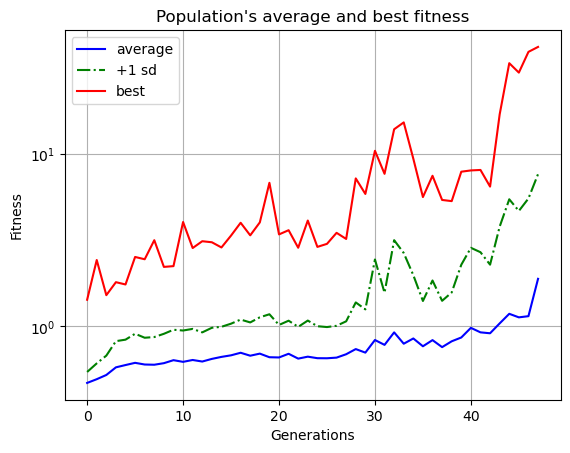

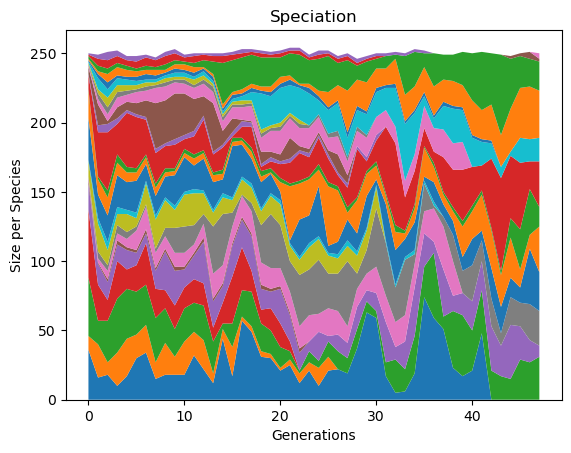

In [45]:
import multiprocessing
import os
import pickle
import cart_pole
import neat
import visualize

runs_per_net = 5
simulation_seconds = 60.0


# Use the NN network phenotype and the discrete actuator force function.
def eval_genome(genome, config):
    net = neat.nn.FeedForwardNetwork.create(genome, config)

    fitnesses = []

    for runs in range(runs_per_net):
        sim = cart_pole.CartPole()

        # Run the given simulation for up to num_steps time steps.
        fitness = 0.0
        while sim.t < simulation_seconds:
            inputs = sim.get_scaled_state()
            action = net.activate(inputs)

            # Apply action to the simulated cart-pole
            force = cart_pole.discrete_actuator_force(action)
            sim.step(force)

            # Stop if the network fails to keep the cart within the position or angle limits.
            # The per-run fitness is the number of time steps the network can balance the pole
            # without exceeding these limits.
            if abs(sim.x) >= sim.position_limit or abs(sim.theta) >= sim.angle_limit_radians:
                break

            fitness = sim.t

        fitnesses.append(fitness)

    # The genome's fitness is its worst performance across all runs.
    return min(fitnesses)


def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = eval_genome(genome, config)


def run():
    # Load the config file, which is assumed to live in
    # the same directory as this script.
    local_dir = os.path.dirname("/media/adi/032E-9FF0/ml/rl/rl-neat-self-balancing-robot-sim-and-algo/rl/config-feedforward")
    config_path = os.path.join(local_dir, 'config-feedforward')
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_path)

    pop = neat.Population(config)
    stats = neat.StatisticsReporter()
    pop.add_reporter(stats)
    pop.add_reporter(neat.StdOutReporter(True))

    pe = neat.ParallelEvaluator(multiprocessing.cpu_count(), eval_genome)
    winner = pop.run(pe.evaluate)

    # Save the winner.
    with open('winner-feedforward', 'wb') as f:
        pickle.dump(winner, f)

    print(winner)

    visualize.plot_stats(stats, ylog=True, view=True, filename="feedforward-fitness.svg")
    visualize.plot_species(stats, view=True, filename="feedforward-speciation.svg")

    node_names = {-1: 'x', -2: 'dx', -3: 'theta', -4: 'dtheta', 0: 'control'}
    visualize.draw_net(config, winner, True, node_names=node_names)

    visualize.draw_net(config, winner, view=True, node_names=node_names,
                       filename="winner-feedforward.gv")


if __name__ == '__main__':
    run()


test feedforward

In [46]:
import os
import pickle
import neat
from cart_pole import CartPole, discrete_actuator_force
from movie import make_movie
# load the winner
with open('winner-feedforward', 'rb') as f:
    c = pickle.load(f)

print('Loaded genome:')
print(c)

# Load the config file, which is assumed to live in
# the same directory as this script.
local_dir = os.path.dirname("/media/adi/032E-9FF0/ml/rl/rl-neat-self-balancing-robot-sim-and-algo/rl/config-feedforward")
config_path = os.path.join(local_dir, 'config-feedforward')
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_path)

net = neat.nn.FeedForwardNetwork.create(c, config)
sim = CartPole()

print()
print("Initial conditions:")
print("        x = {0:.4f}".format(sim.x))
print("    x_dot = {0:.4f}".format(sim.dx))
print("    theta = {0:.4f}".format(sim.theta))
print("theta_dot = {0:.4f}".format(sim.dtheta))
print()

# Run the given simulation for up to 120 seconds.
balance_time = 0.0
while sim.t < 120.0:
    inputs = sim.get_scaled_state()
    action = net.activate(inputs)

    # Apply action to the simulated cart-pole
    force = discrete_actuator_force(action)
    sim.step(force)

    # Stop if the network fails to keep the cart within the position or angle limits.
    # The per-run fitness is the number of time steps the network can balance the pole
    # without exceeding these limits.
    if abs(sim.x) >= sim.position_limit or abs(sim.theta) >= sim.angle_limit_radians:
        break

    balance_time = sim.t

print('Pole balanced for {0:.1f} of 120.0 seconds'.format(balance_time))

print()
print("Final conditions:")
print("        x = {0:.4f}".format(sim.x))
print("    x_dot = {0:.4f}".format(sim.dx))
print("    theta = {0:.4f}".format(sim.theta))
print("theta_dot = {0:.4f}".format(sim.dtheta))
print()
print("Making movie...")
make_movie(net, discrete_actuator_force, 15.0, "feedforward-movie.mp4")


Loaded genome:
Key: 9913
Fitness: 60.00999999999663
Nodes:
	0 DefaultNodeGene(key=0, bias=-2.407999369417393, response=1.0, activation=sigmoid, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-4, 0), weight=2.87343855986778, enabled=True)
	DefaultConnectionGene(key=(-3, 0), weight=0.4719637002492898, enabled=True)
	DefaultConnectionGene(key=(-2, 0), weight=1.4705881541820522, enabled=True)

Initial conditions:
        x = -0.2399
    x_dot = -0.8480
    theta = -0.2939
theta_dot = -0.0827

Pole balanced for 2.3 of 120.0 seconds

Final conditions:
        x = -2.4218
    x_dot = -6.8992
    theta = -0.2751
theta_dot = 2.1320

Making movie...
Moviepy - Building video feedforward-movie.mp4.
Moviepy - Writing video feedforward-movie.mp4



Moviepy - Done !
Moviepy - video ready feedforward-movie.mp4
